In [1]:
import json
import os
import math
import joblib
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

### Setup
#### Create two dataframes:
1. **df_init**: all covid stories
2. **df_balanced**: balanced sample of df_init used for testing/training ML models

In [2]:
def load_data(directory):
    data_dicts = []
    for file in os.listdir(directory):
        with open(os.path.join(directory, file), 'r') as f:
            data_dict = json.load(f)
        data_dicts.append(data_dict)
    return data_dicts

In [3]:
def build_dataframe(data_dicts):
    return pd.json_normalize(data_dicts)

def reformat_dataframe(df, columns_to_keep):
    df = df.rename(columns_to_keep, axis=1)
    df = df[list(columns_to_keep.values())]
    return df

In [4]:
def drop_unlabeled_data(df, column):
    return df[(df[column] == True) | (df[column] == False)]
def balance_data(df, column):
    df_grouped = df.groupby(column)
    sample_size = df_grouped.size().min()

    def sample(df):
        return df.sample(sample_size)

    df_grouped_sampled = df_grouped.apply(sample)
    df_sampled = pd.DataFrame(df_grouped_sampled)
    df_sampled = df_sampled.droplevel(level=0)
  
    return df_sampled

In [5]:
def print_useful_info(df,column="_label", name= ""):
    print(f"# stories {name}\t: {df.shape[0]} ({100*(df[df[column] == True].shape[0]/df.shape[0]):.2f}% COVID)")

In [6]:
directory = '../data/news_articles/balanced_dataset/'
columns_to_keep = {
    'LABEL.WANT_ON_MAP': '_label',
    'ARTICLE.TEXT': 'text',
    'ARTICLE.TITLE': 'title'}
label = '_label' # put '_' in front so that it does not conflict with columns for tfidf vectors later on
content_columns = ['text','title']

data = load_data(directory)

df_init = build_dataframe(data)
df_init = reformat_dataframe(df_init, columns_to_keep)
df_init = drop_unlabeled_data(df_init, label)
df_init[label] = df_init[label].astype(bool)

df_balanced = balance_data(df_init, label)
    
print("data loaded")
print_useful_info(df_init, name='all data')
print_useful_info(df_balanced, name='balanced data')

data loaded
# stories all data	: 1589 (10.70% COVID)
# stories balanced data	: 340 (50.00% COVID)


### Rule Based Model

In [7]:
def predict_with_rules(df, keyword_string, title_col='title',content_col='text'):
    return df[title_col].str.contains(pat=keyword_string, case=False,regex = True) | (df[content_col].str.lower().str.count(keyword_string) > 5)

def plot_cf_matrix(labels,predicted, title= "", normalize=None):
    ax= plt.subplot()
    matrix = confusion_matrix(labels, predicted, normalize=normalize)
    display = ConfusionMatrixDisplay(matrix, display_labels=['Not COVID','COVID'])
    display.plot(cmap='Blues',ax=ax)
    ax.set_title(title)

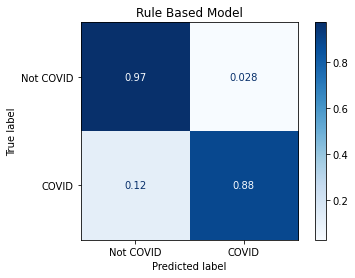

In [8]:
keyword_string = 'covid|corona|pandem|epidem|mask|quarant|vaccine|lockdown'
predicted = predict_with_rules(df_init[content_columns], keyword_string)
labels = df_init[label]

plot_cf_matrix(labels, predicted, title="Rule Based Model", normalize='true')

### Keyword model 

In [9]:
def count_keywords(df, columns, keywords):
    for keyword in keywords:

        def count_keyword(string):
            return sum(
                keyword in word
                for word in string.lower().split())

        df[keyword] = df[columns].applymap(count_keyword).sum(axis=1)
    return df

def train_classifiers(classifiers, x,y, debug=False):
    for cls in classifiers:
        if debug: print(type(cls).__name__ + "... ",end="")
        cls.fit(x,y)
        if debug: print("done")

In [10]:
def plot_confusion_matrices(classifiers, x,y,title="",normalize=None, nrows = 1):
    ncols = math.ceil(len(classifiers)/nrows)
    fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(ncols*5,nrows*3.7))
    for cls, ax in zip(classifiers, axes.flatten()):
        plot_confusion_matrix(cls,
                      x, 
                      y,
                      ax=ax, 
                      cmap='Blues',
                      normalize = normalize,
                     display_labels=['Not COVID','COVID'])
        ax.title.set_text(type(cls).__name__)
    fig.suptitle(title, fontsize='xx-large',ha='left')
    plt.tight_layout()  
    plt.show()

In [11]:
article_keywords = [
        'covid',
        'corona',
        'pandem',
        'epidem',
        'mask',
        'quarant',
        'vaccine',
        ]
classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
]

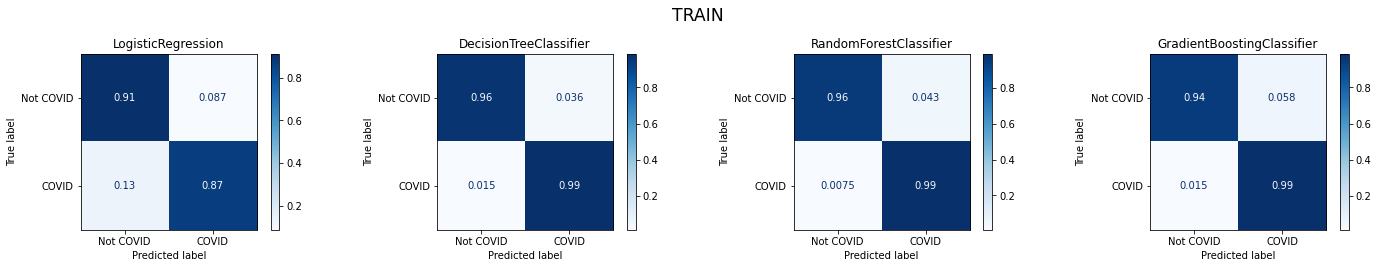

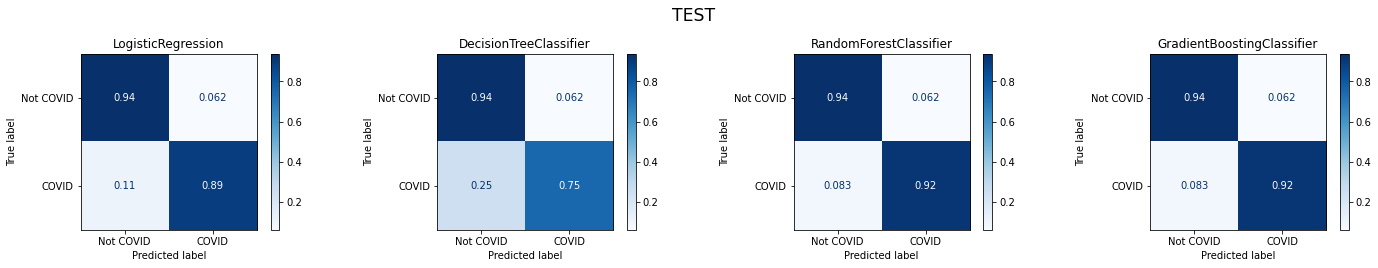

In [12]:
df = count_keywords(df_balanced, content_columns, article_keywords)
X = df[article_keywords]
y = df[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

train_classifiers(classifiers,X_train, y_train)

plot_confusion_matrices(classifiers, X_train, y_train,title="TRAIN", normalize='true')
plot_confusion_matrices(classifiers, X_test, y_test,title="TEST", normalize='true')

### TF IDF VECTORIZE

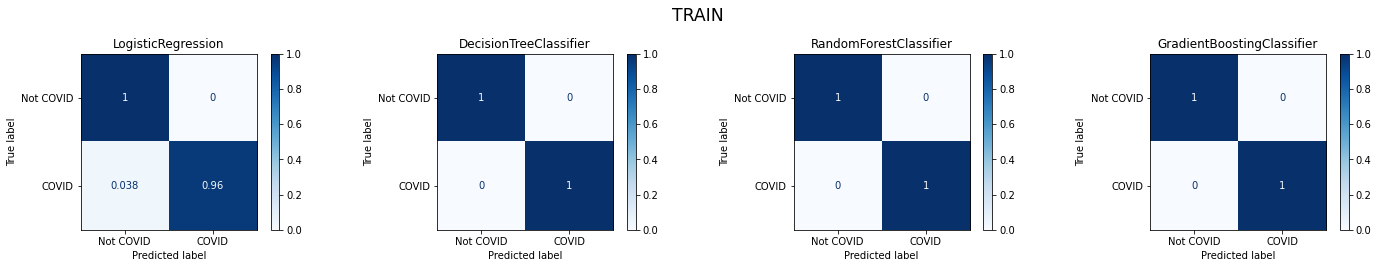

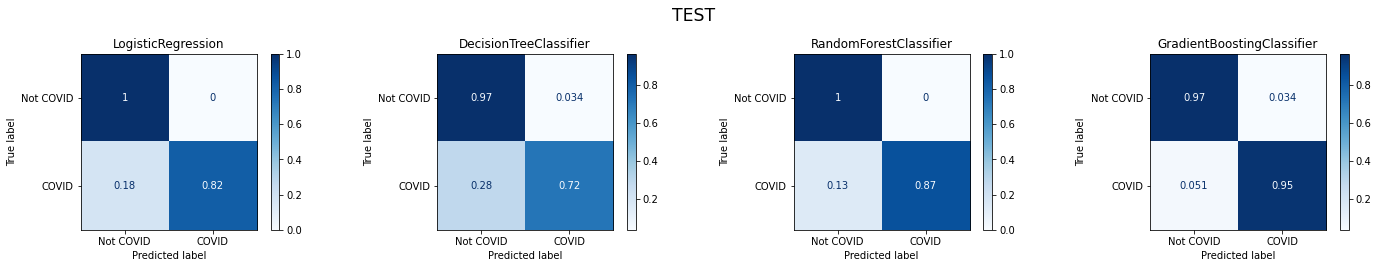

In [13]:
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')

X = tfidfvectorizer.fit_transform(df_balanced['text'])
y = df_balanced[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

train_classifiers(classifiers,X_train, y_train)

plot_confusion_matrices(classifiers, X_train, y_train,title="TRAIN", normalize='true')
plot_confusion_matrices(classifiers, X_test, y_test,title="TEST", normalize='true')

### Threshold analysis
##### Increase threshold to limit false positives, since 90% of stories scraped are not COVID related
##### Best threshold must also not create too many new false negatives 

In [14]:
def _scatter_plot_threshold(threshold_range, false_negatives, false_positives, title=""):
    x = threshold_range 
    fig = go.Figure(data=[
                        go.Scatter(x=x, y=false_negatives, name= "False Negative: % of actual covid stories missed"),
                        go.Scatter(x=x, y=false_positives, name= "False Positive: % stories on map false"),
                        go.Scatter(x=x, y=100-np.array(false_negatives), name= "% covid stories identified"),
                         ])
    fig.update_xaxes(
        tickangle = 90,
        title_text = "Threshold",
        title_standoff = 25)
    fig.update_yaxes(
        title_text = "Percent",
        title_standoff = 25)
    fig.update_layout(title_text=title)
    fig.show()
    
def plot_threshold_accuracy(classifier, X, y, threshold_range):
    prob_of_success = classifier.predict_proba(X)[:,1]
    total_positives = y[y].shape[0]
    if total_positives == 0:
        total_positives = math.inf # avoid dividing by 0
    false_positives = []
    false_negatives = []
    for threshold in threshold_range:
        predictions  = prob_of_success > threshold 
        on_map = predictions[predictions].shape[0]
        if on_map == 0:
            on_map = math.inf # avoid dividing by 0
        false_p = predictions[predictions & (~y)].shape[0]
        false_n = predictions[(~predictions) & y].shape[0]
        false_positives.append((false_p)/(on_map)*100)
        false_negatives.append((false_n)/(total_positives)*100)
    _scatter_plot_threshold(threshold_range, false_negatives, false_positives, title=type(classifier).__name__)

In [15]:
def get_ratio_true_false(df, column):
    nrows_true = df[df[column] == True].shape[0]
    nrows_false = df[df[column] == False].shape[0]
    return nrows_true/nrows_false 

In [22]:
# SETUP: get test data with the same proportion of covid to non-covid stories as original dataset
train_indeces = y_train.index.values
test_data = df_init[(~df_init.index.isin(train_indeces))]

test_true = test_data[test_data[label] == True] 
test_false = test_data[test_data[label] == False]
nrows_true = test_true.shape[0]
ratio = 1/get_ratio_true_false(df_init,label)

df_sample = pd.concat([test_true, 
                       test_false.sample(n=int(nrows_true*ratio))
                      ])
print_useful_info(df_sample, name="test data sample")

# stories test data sample	: 364 (10.71% COVID)


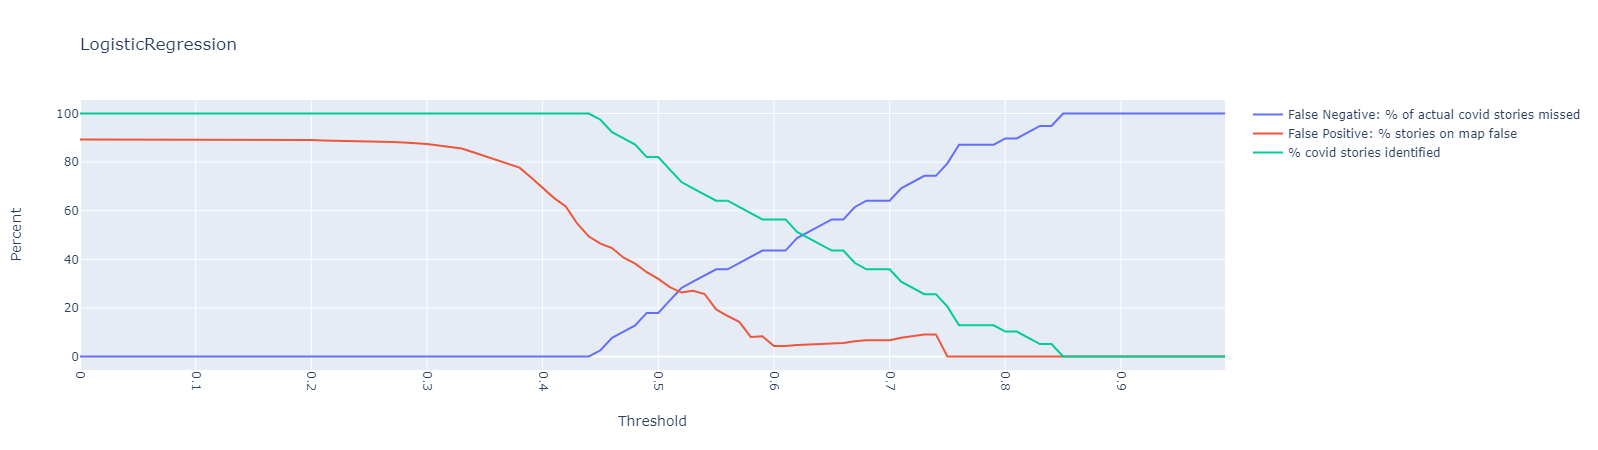

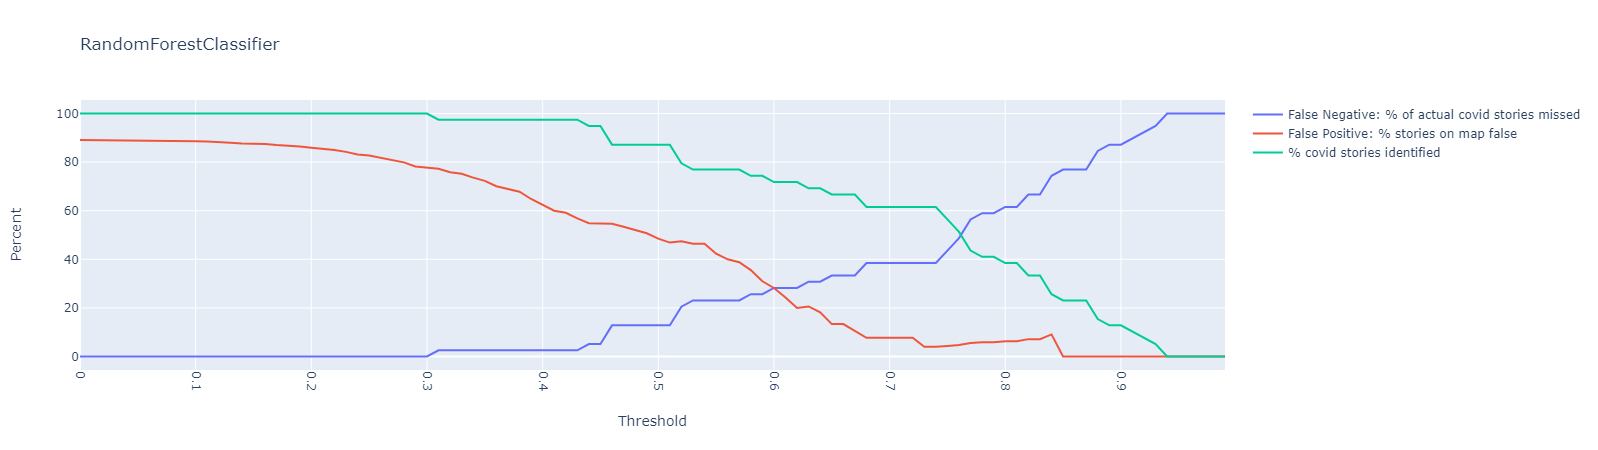

In [23]:
X = tfidfvectorizer.transform(df_sample['text'])
y = df_sample[label]
plot_threshold_accuracy(classifiers[0],X,y,np.arange(0,1,.01))
plot_threshold_accuracy(classifiers[2],X,y,np.arange(0,1,.01))

### export model

In [18]:
model=classifiers[2] 
name = 'model.pkl'
joblib.dump(model, name)
print(f"success: model stored in file \"{name}\"")

success: model stored in file "model.pkl"


In [19]:
pickle.dump(tfidfvectorizer, open("tfidf.pkl", "wb"))
print(f"success: tfidf vectorizer stored in file \"{name}\"")

success: tfidf vectorizer stored in file "model.pkl"
